In [1]:
import numpy as np
import xray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm

In [2]:
#from xgcm import mdsxray
#from xgcm.gridops import MITgcmDataset
import xgcm

In [3]:
iters = [1,]
ddir = '/home/rpa/MITgcm/verification/global_oce_latlon_WOA/run'
#store = mdsxray.MDSDataStore(ddir, iters, deltaT=86400, 
#                             prefix=['DiagGAD-T', 'DiagGAD-S','T','S'])
#ds = xray.Dataset.load_store(store)
ds = xgcm.open_mdsdataset(ddir, iters, deltaT=86400, 
                             prefix=['DiagGAD-T', 'DiagGAD-S','T','S'])
ds

xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xray.Dataset>
Dimensions:   (X: 360, Xp1: 360, Y: 160, Yp1: 160, Z: 102, Zl: 102, Zp1: 103, Zu: 102, time: 1)
Coordinates:
  * Xp1       (Xp1) >f4 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 -174.0 ...
  * Zl        (Zl) >f4 0.0 -2.5 -7.5 -12.5 -17.5 -22.5 -27.5 -32.5 -37.5 ...
  * Yp1       (Yp1) >f4 -80.0 -79.0 -78.0 -77.0 -76.0 -75.0 -74.0 -73.0 ...
  * Zp1       (Zp1) >f4 0.0 -2.5 -7.5 -12.5 -17.5 -22.5 -27.5 -32.5 -37.5 ...
  * Y         (Y) >f4 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 ...
  * X         (X) >f4 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * Z         (Z) >f4 -1.25 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 ...
  * Zu        (Zu) >f4 -2.5 -7.5 -12.5 -17.5 -22.5 -27.5 -32.5 -37.5 -42.5 ...
  * time      (time) int64 86400
Data variables:
    YC        (Y, X) >f4 -79.5 -79.5 -79.5 -79.5 -79.5 -79.5 -79.5 -79.5 ...
    YG        (Yp1, Xp1) >f4 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 ...
    rA        (Y, X) >f4 2.25248e+09 2.25248e+09

(1, 102, 160, 360)
(1, 102, 160, 360)


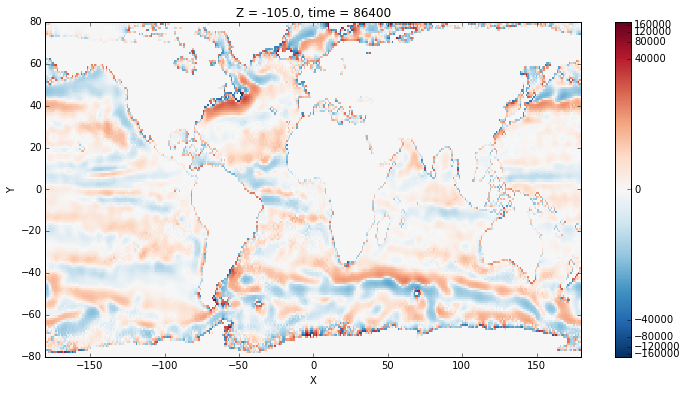

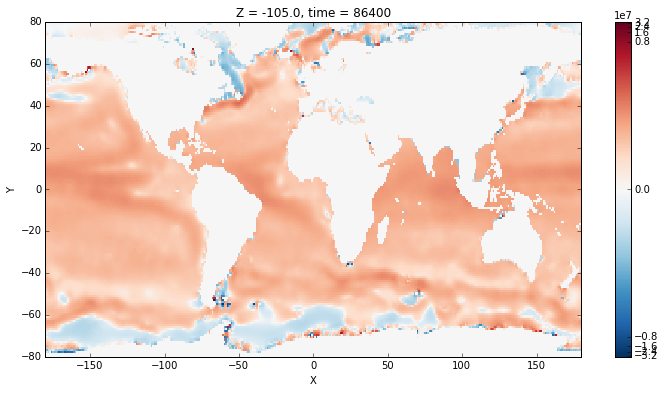

In [4]:
mitgcm = xgcm.MITgcmDataset(ds)

th_hdiff = (mitgcm.diff_xp1_to_x(ds.DFxE_TH) 
            + mitgcm.diff_yp1_to_y(ds.DFyE_TH) )
th_vdiff = (mitgcm.diff_zl_to_z(ds.DFrE_TH)
            + mitgcm.diff_zl_to_z(ds.DFrI_TH))

plt.figure(figsize=(12,6))
th_hdiff[0,20].plot.pcolormesh(norm=SymLogNorm(1e3))

plt.figure(figsize=(12,6))
th_vdiff[0,20].plot.pcolormesh(norm=SymLogNorm(1e3))

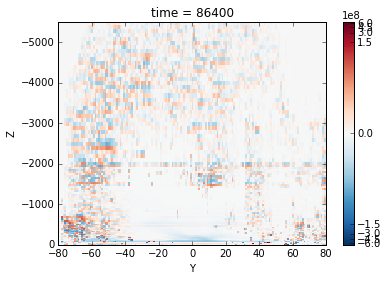

In [18]:
xray.plot.pcolormesh(th_vdiff[0].sum(dim=('X')), norm=SymLogNorm(1e6))


In [213]:
darr = ds['T']
darr_roll = mitgcm.roll(darr, -10, 'X')
np.testing.assert_allclose(darr_roll[0,0].values,
                           np.roll(darr[0,0].values,-10,axis=-1))

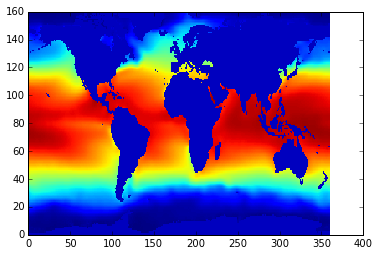

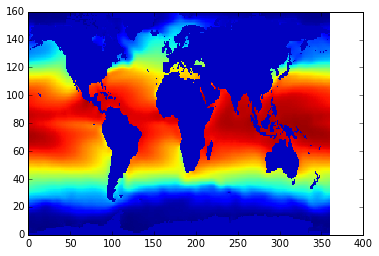

In [214]:
plt.pcolormesh(darr[0,0].values)
plt.figure()
plt.pcolormesh(darr_roll[0,0].values)

In [242]:
darr_diff = mitgcm.diff_zl_to_z(ds.DFrI_SLT)
darr_diff

(1, 102, 160, 360)


<xray.DataArray 'DFrI_SLT_diff_zl_to_z' (time: 1, Z: 102, Y: 160, X: 360)>
dask.array<x_573, shape=(1, 102, 160, 360), chunks=((1,), (102,), (160,), (360,)), dtype=float32>
Coordinates:
  * Y        (Y) >f4 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 ...
  * X        (X) >f4 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 ...
  * Z        (Z) >f4 -1.25 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 ...
  * time     (time) int64 86400

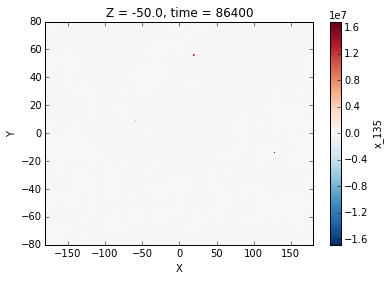

In [161]:
darr_diff[0,10].plot.pcolormesh()

In [112]:
len(darr_zp1.Zp1)

103

In [230]:
list(range(5))

[0, 1, 2, 3, 4]

In [4]:
# make some functions for taking divergence
from dask import array as da

class MITgcmDataset(object):

    def __init__(self, ds):
        self.ds = ds

    def _get_coords_from_dims(self, dims, replace=None):
        dims = list(dims)
        if replace:
            for k in replace:
                dims[dims.index(k)] = replace[k]
        return {dim: self.ds[dim] for dim in dims}, dims
    
    def extend_zl_to_zp1(self, darr, fill_value=0.):
        coords, dims = self._get_coords_from_dims(darr.dims)
        zdim = dims.index('Zl')
        # shape of the new array to concat at the bottom
        shape = list(darr.shape)
        shape[zdim] = 1
        # replace Zl with the bottom level
        coords['Zl'] = np.atleast_1d(self.ds['Zp1'][-1].data)
        # an array of zeros at the bottom
        # need different behavior for numpy vs dask
        if darr.chunks:
            chunks = list(darr.data.chunks)
            chunks[zdim] = (1,)
            zarr = fill_value * da.ones(shape, dtype=darr.dtype, chunks=chunks)
        else:
            zarr = np.zeros(shape, darr.dtype)
        zeros = xray.DataArray(zarr, coords, dims)
        newdarr = xray.concat([darr, zeros], dim='Zl').rename({'Zl':'Zp1'})
        if newdarr.chunks:
            return newdarr.chunk({'Zp1': len(newdarr.Zp1)})
        else:
            return newdarr

    def diff_zp1_to_z(self, darr):
        a_up = darr.isel(Zp1=slice(None,-1))
        a_dn = darr.isel(Zp1=slice(1,None))
        a_diff = a_up.data - a_dn.data
        print a_diff.shape
        # dimensions and coords of new array
        coords, dims = self._get_coords_from_dims(darr.dims, replace={'Zp1':'Z'})
        return xray.DataArray(a_diff, coords, dims,
                              name=darr.name+'_diff_zp1_to_z')
    
    def diff_zl_to_z(self, darr):
        darr_zp1 = self.extend_zl_to_zp1(darr)
        darr_diff = self.diff_zp1_to_z(darr_zp1)
        return darr_diff.rename(darr.name + '_diff_zl_to_z')
    
    # doesn't actually need parent ds
    # this could go in xray
    def roll(self, darr, n, dim):
        """Clone of numpy.roll for xray DataArrays."""
        left = darr.isel(**{dim:slice(None,-n)})
        right = darr.isel(**{dim:slice(-n,None)})
        return xray.concat([right, left], dim=dim)
    
    def diff_xp1_to_x(self, darr):
        """Difference DataArray ``darr`` in the x direction.
        Assumes that ``darr`` is located at the xp1 point."""
        left = darr
        right = self.roll(darr, -1, 'Xp1')
        if darr.chunks:
            right = right.chunk(darr.chunks)
        diff = right.data - left.data
        coords, dims = self._get_coords_from_dims(darr.dims, replace={'Xp1':'X'})
        return xray.DataArray(diff, coords, dims
                              ).rename(darr.name + '_diff_xp1_to_x')
    
    def diff_yp1_to_y(self, darr):
        """Difference DataArray ``darr`` in the y direction.
        Assumes that ``darr`` is located at the yp1 point."""
        left = darr
        right = self.roll(darr, -1, 'Yp1')
        if darr.chunks:
            right = right.chunk(darr.chunks)
        diff = right.data - left.data
        coords, dims = self._get_coords_from_dims(darr.dims, replace={'Yp1':'Y'})
        return xray.DataArray(diff, coords, dims
                              ).rename(darr.name + '_diff_yp1_to_y')
        

In [14]:
mask.shape

(102, 160, 360)

In [15]:
woamask.shape

(102, 160, 360)

In [16]:
dar

<xray.DataArray 'HFacC' ()>
array(2822542)

In [17]:
woamask.sum()

2822542

In [18]:
(mask - woamask).sum()

<xray.DataArray 'HFacC' ()>
array(0)

In [162]:
darr_diff.rename('test')
darr_diff

<xray.DataArray 'x_135' (time: 1, Z: 102, Y: 160, X: 360)>
dask.array<x_135, shape=(1, 102, 160, 360), chunks=((1,), (102,), (160,), (360,)), dtype=float32>
Coordinates:
  * Y        (Y) >f4 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 ...
  * X        (X) >f4 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 ...
  * Z        (Z) >f4 -1.25 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 ...
  * time     (time) int64 86400

In [23]:
ds['Zp1'][-1].values

array(-5500.0, dtype=float32)

In [101]:
isinstance(darr.data, da.Array)

True

In [231]:
for k in {'a': 1, 'b': 2}:
    print k

a
b
